# Outline

### For this project I've done following

#### Preprocesing:
I merged the train and test dataframes from separated files and adding the column for each emotion that could take either value 1 or 0, and is responsible for the actual emotion-label.
My prepText function is the one to remove 1 letter words, remove Twitter nicknames, remove tags,remove punctuation and digits, as well as removing stop words.
I tried Lemmatization on the set, but due to the size of corpus, I had to refuse this idea, due to the lack of computational power.

#### Models:
I tried couple of models, such as naive_bayes with BOW500, keras with BOW500 and keras with glove100


In [1]:
from collections import defaultdict
import nltk
import random
import gensim
import numpy as np
from nltk.corpus import stopwords
import string
import re
import pandas as pd
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/daria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
stop_words=set(stopwords.words("english"))

In [4]:
f=open('data_identification.csv', 'r') 
f1=open('emotion.csv', 'r') 
f2=open('tweets_DM.json', 'r') 

In [5]:
import json

In [6]:
emo= pd.read_csv(f1)
ident= pd.read_csv(f)
tweets= pd.read_json(f2, lines=True)

In [7]:
test = ident[ident['identification']=='test']
train = ident[ident['identification']=='train']

In [8]:
from pandas.io.json import json_normalize

In [9]:
tweets_source = pd.DataFrame()

In [10]:
tweets_source[['tweet_id','text']]=json_normalize(tweets['_source'])[['tweet.tweet_id','tweet.text']]

In [11]:
tweets_source

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [11]:
train=train.merge(emo, how='left') #merging databases

In [12]:
train=train.merge(tweets_source, how='left')

In [13]:
test=test.merge(tweets_source, how='left')

In [14]:
def prepText(text):
  text= re.compile(r'(.)\1{1,}',re.IGNORECASE).sub(r'\1',text) # remove 1 letter words
  text = re.sub('@[^\s]+','',text) #remove nicknames
  text = re.sub('#[^\s]+','',text)#remove tags
  t = text.translate(translator)#remove punctuation
  tokens = t.split()
  words = [tokens[i].lower() for i,word in enumerate(tokens) if word.lower() not in stop_words]#remove stop words
  return ' '.join(words)

In [15]:
translator = str.maketrans('', '', string.punctuation+'0123456789')

In [16]:
e=['joy','trust','anticipation','disgust','sadness','anger','fear','surprise']
for i in e:
  train[i]=0
  test[i]=0

In [17]:
train_short = pd.DataFrame()
ttest = pd.DataFrame()

In [18]:
for i in e:
  train_short =train_short.append(train[train['emotion']==i][:25000], ignore_index=True)
  ttest = ttest.append(train[train['emotion']==i][25000:27000], ignore_index=True)


In [19]:
for j,i in enumerate(train_short['text']): 
  train_short.at[j, 'text']= prepText(i)
  train_short.at[j, train_short.iloc[j]['emotion']]= 1

In [20]:
for j,i in enumerate(ttest['text']):
  ttest.at[j, 'text']= prepText(i)
  ttest.at[j, ttest.iloc[j]['emotion']]= 1

In [21]:
for j,i in enumerate(test['text']):
  test.at[j, 'text']= prepText(i)

In [26]:
train_short=train_short.sample(frac=1)
ttest=ttest.sample(frac=1)
X_train = train_short['text'].values
y_train = train_short[e]
X_test =  test['text'].values

In [27]:
X_ttest = ttest['text'].values
y_ttest = ttest[e]

In [28]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 
BOW_500.fit(train_short['text'])

train_data_BOW_features_500 = BOW_500.transform(train_short['text'])

train_data_BOW_features_500.shape
feature_names_500 = BOW_500.get_feature_names()

from sklearn.naive_bayes import MultinomialNB
X_train = BOW_500.transform(train_short['text'])
y_train = train_short['emotion']
X_test = BOW_500.transform(ttest['text'])
y_test = ttest['emotion']
clf = MultinomialNB()
clf=clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

training accuracy: 0.29
testing accuracy: 0.29
              precision    recall  f1-score   support

       anger       0.32      0.26      0.29      2000
anticipation       0.25      0.47      0.33      2000
     disgust       0.23      0.25      0.24      2000
        fear       0.35      0.37      0.36      2000
         joy       0.32      0.19      0.24      2000
     sadness       0.28      0.20      0.23      2000
    surprise       0.28      0.22      0.25      2000
       trust       0.30      0.32      0.31      2000

    accuracy                           0.29     16000
   macro avg       0.29      0.29      0.28     16000
weighted avg       0.29      0.29      0.28     16000

[[526 324 323 231  98 178 159 161]
 [121 941 153 171 126 115 113 260]
 [239 392 497 207  79 208 217 161]
 [137 355 182 743 129 122 177 155]
 [104 479 150 196 378 124 144 425]
 [204 352 361 198  99 405 187 194]
 [170 386 304 250 105 180 439 166]
 [122 477 163 146 184 131 132 645]]


In [30]:
import keras

X_train = BOW_500.transform(train_short['text'])
y_train = train_short['emotion']

X_test = BOW_500.transform(ttest['text'])
y_test = ttest['emotion']

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)


X_train.shape:  (200000, 500)
y_train.shape:  (200000,)
X_test.shape:  (16000, 500)
y_test.shape:  (16000,)


In [31]:

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)


check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:4]:
 89019      disgust
197540    surprise
89593      disgust
179299    surprise
Name: emotion, dtype: object

y_train.shape:  (200000,)
y_test.shape:  (16000,)


## After convert
y_train[0:4]:
 [[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]

y_train.shape:  (200000, 8)
y_test.shape:  (16000, 8)
input_shape:  500
output_shape:  8


In [32]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

model_input = Input(shape=(input_shape, ))  
X = model_input

X_W1 = Dense(units=64)(X)  
H1 = ReLU()(X_W1)

H1_W2 = Dense(units=64)(H1)  
H2 = ReLU()(H1_W2)

H2_W3 = Dense(units=output_shape)(H2) 
H3 = Softmax()(H2_W3)

model_output = H3

model = Model(inputs=[model_input], outputs=[model_output])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32064     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
softmax_1 (Softmax)          (None, 8)                 0   

In [33]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('logs/training_log.csv')

epochs = 3
batch_size = 32

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')



Train on 200000 samples, validate on 16000 samples
Epoch 1/3
200000/200000 [==============================] - 8s 42us/step - loss: 1.8481 - accuracy: 0.2832 - val_loss: 1.8050 - val_accuracy: 0.3041
Epoch 2/3
200000/200000 [==============================] - 8s 39us/step - loss: 1.7972 - accuracy: 0.3085 - val_loss: 1.7954 - val_accuracy: 0.3078
Epoch 3/3
200000/200000 [==============================] - 8s 40us/step - loss: 1.7750 - accuracy: 0.3185 - val_loss: 1.7963 - val_accuracy: 0.3116
training finish


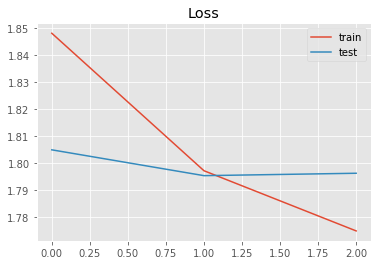

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

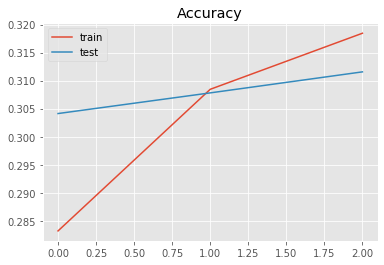

In [35]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [42]:
X1_test=pd.DataFrame()
X1_train=pd.DataFrame()

In [43]:
for i in e:
  X1_train =X1_train.append(train[train['emotion']==i][:15000], ignore_index=True)
  X1_test = X1_test.append(train[train['emotion']==i][26000:27000], ignore_index=True)

for j,i in enumerate(X1_train['text']):
  X1_train.at[j, 'text']= prepText(i)
  X1_train.at[j, X1_train.iloc[j]['emotion']]= 1

for j,i in enumerate(X1_test['text']):
  X1_test.at[j, 'text']= prepText(i)
  X1_test.at[j, X1_test.iloc[j]['emotion']]= 1

X1_train=X1_train.sample(frac=1)
X1_test=X1_test.sample(frac=1)
y1_test=X1_test[e]
y1_train = X1_train[e]
X1_train = X1_train['text'].values
X1_test =  X1_test['text'].values

In [44]:
X_test

<16000x500 sparse matrix of type '<class 'numpy.int64'>'
	with 66728 stored elements in Compressed Sparse Row format>

In [45]:
tokenizer1 = Tokenizer(num_words=20000)
tokenizer1.fit_on_texts(X1_train)

X1_train = tokenizer1.texts_to_sequences(X1_train)
X1_test = tokenizer1.texts_to_sequences(X1_test)

vocab_size = len(tokenizer1.word_index) + 1

maxlen = 500

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

In [46]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer1.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [47]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(8, activation='sigmoid')(LSTM_Layer_1)
model1 = Model(inputs=deep_inputs, outputs=dense_layer_1)
from keras.optimizers import SGD
opt = SGD(lr=0.01)
model1.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['acc'])


In [48]:
print(model1.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 100)          6277900   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1032      
Total params: 6,396,180
Trainable params: 118,280
Non-trainable params: 6,277,900
_________________________________________________________________
None


In [49]:
history1 = model1.fit(X1_train, y1_train, batch_size=128, epochs=3, validation_data=(X1_test, y1_test))

Train on 120000 samples, validate on 8000 samples
Epoch 1/3
120000/120000 [==============================] - 547s 5ms/step - loss: 2.0795 - acc: 0.1234 - val_loss: 2.0794 - val_acc: 0.1250
Epoch 2/3
120000/120000 [==============================] - 532s 4ms/step - loss: 2.0795 - acc: 0.1237 - val_loss: 2.0794 - val_acc: 0.1250
Epoch 3/3
120000/120000 [==============================] - 528s 4ms/step - loss: 2.0795 - acc: 0.1244 - val_loss: 2.0794 - val_acc: 0.1250


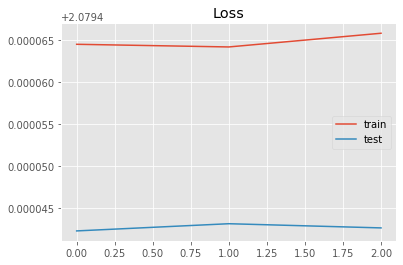

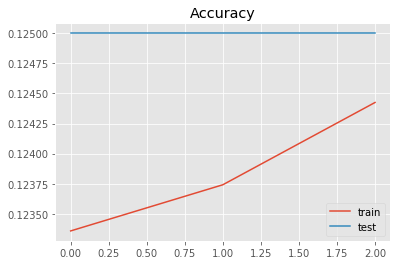

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.title('Loss')
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history1.history['acc'], label='train')
plt.plot(history1.history['val_acc'], label='test')
plt.legend()
plt.show()

In [ ]:
###The keras + glove gave me low results due to the relatively small corpus and few iterations, unfortunately i cannot fix it in the very this moment

In [36]:
ynew = []
for i in test['text']:
    ynew.append(model.predict(BOW_500.transform([i])))

In [37]:
ynew

[array([[0.06749716, 0.08848425, 0.1975862 , 0.11936665, 0.13912033,
         0.12468469, 0.16919689, 0.09406383]], dtype=float32),
 array([[0.07644488, 0.07352889, 0.13684955, 0.14850384, 0.14215383,
         0.13789791, 0.11153264, 0.17308846]], dtype=float32),
 array([[0.04914432, 0.25804153, 0.14364286, 0.03300641, 0.19274382,
         0.09092734, 0.09682799, 0.1356658 ]], dtype=float32),
 array([[0.06939435, 0.18547611, 0.08849907, 0.16983645, 0.13358071,
         0.08116955, 0.09576137, 0.17628239]], dtype=float32),
 array([[0.17131568, 0.03529451, 0.27674428, 0.07098153, 0.02726578,
         0.24070019, 0.15021953, 0.02747851]], dtype=float32),
 array([[0.03912682, 0.05401748, 0.04880499, 0.04608239, 0.61942714,
         0.05261143, 0.06016237, 0.07976745]], dtype=float32),
 array([[0.00139328, 0.0100216 , 0.00183426, 0.00509147, 0.3356792 ,
         0.00359784, 0.00346098, 0.6389214 ]], dtype=float32),
 array([[0.04285219, 0.18306305, 0.11167861, 0.1126522 , 0.04274962,
       

In [38]:
yn= ynew

In [67]:
len(test['text'].values)

411972

In [39]:
for j,i in enumerate(test['text']): 
  test.at[j, 'emotion']= e[np.argmax(yn[j])]

In [40]:
test[30:40]

,tweet_id,identification,text,joy,trust,anticipation,disgust,sadness,anger,fear,surprise,emotion
30,0x3764f4,test,two hour wait colect car lihue meant mised exc...,0,0,0,0,0,0,0,0,joy
31,0x301769,test,joy watch hong chau stoped fans say much loved...,0,0,0,0,0,0,0,0,sadness
32,0x352230,test,spent day droping people fet air detonator get...,0,0,0,0,0,0,0,0,joy
33,0x2d19aa,test,stufed crust piza coke craig’s standup breakfa...,0,0,0,0,0,0,0,0,anticipation
34,0x2d38a7,test,kid thought k nazis would history also thought...,0,0,0,0,0,0,0,0,anger
35,0x30de6b,test,things aren’t going right absolute best family...,0,0,0,0,0,0,0,0,surprise
36,0x3802dc,test,don’t let yesterday’s semingly unanswered pray...,0,0,0,0,0,0,0,0,trust
37,0x2d9e68,test,saying godbye wonderful em family tomorow 😢 ma...,0,0,0,0,0,0,0,0,anger
38,0x2bd747,test,al reading scripts paid “speak” someone elses ...,0,0,0,0,0,0,0,0,anticipation
39,0x3265f1,test,constantly radio mids smal sang lot lh,0,0,0,0,0,0,0,0,anticipation


In [44]:
f=pd.DataFrame()
f[['id','emotion']] = test[['tweet_id','emotion']]

In [ ]:
from google.colab import files
f.download("data.csv")

In [47]:
export_csv = f.to_csv (r'results.csv', index = None, header=True)